In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import trange

T.__version__

'1.3.1'

In [2]:
def nn_dense(i, o, a=None):
    if a is None:
        return nn.Linear(i, o)
    return nn.Sequential(
        nn.Linear(i, o),
        a(),
    )

def nn_reshape(*shape):
    class Reshape(nn.Module):
        def forward(self, x):
            bs = x.size(0)
            return x.reshape((bs, *shape))
    return Reshape()

def nn_conv(i, o, ks, s, a=nn.Tanh, p=None, d=1):
    if p is None:
        p = ks // 2

    return nn.Sequential(
        nn.Conv2d(i, o, ks, s, p, d),
        nn.BatchNorm2d(o),
        a(),
    )

def nn_conv_transpose(i, o, ks, s, a=nn.Tanh, p=0, d=1):
    return nn.Sequential(
        nn.ConvTranspose2d(i, o, ks, s, padding=(p, p), dilation=d),
        nn.BatchNorm2d(o),
        a(),
    )

In [123]:
class Generator(nn.Module):
    def __init__(self, filters, depth, img_channels):
        super().__init__()

        reshaper = nn_reshape(filters, 1, 1)
        layers = [nn_conv_transpose(filters, filters // 2, ks=3, s=2, p=0)]

        for d in range(depth - 1):
            filters //= 2
            l = nn_conv_transpose(filters, filters // 2, ks=3, s=2, p=0)
            layers.append(l)

        self.net = nn.Sequential(
            reshaper,
            *layers,
            nn_conv_transpose(filters // 2, img_channels, ks=2, s=1, a=nn.Sigmoid)
        )

    def forward(self, z):
        return self.net(z)

In [124]:
class Discriminator(nn.Module):
    def __init__(self, in_chanels, depth):
        super().__init__()

        filters = 1
        layers = [
            nn_conv(in_chanels, filters, ks=3, s=1, p=1),
            nn_conv(filters, filters * 2, ks=3, s=2)
        ]

        for d in range(depth + 1):
            filters *= 2
            l = nn_conv(filters, filters * 2, ks=3, s=2, p=1)
            layers.append(l)

        self.net = nn.Sequential(
            *layers,
            nn_reshape(-1),
        )

    def forward(self, z):
        return self.net(z)

In [125]:
class InverseAE(nn.Module):
    def __init__(self, filters, depth, img_channels):
        super().__init__()
        
        self.message_size = filters
        self.g = Generator(filters, depth, img_channels)
        self.d = Discriminator(img_channels, depth)
        
    @property
    def device(self):
        return next(self.g.parameters()).device
        
    def sample(self, bs):
        return (T.normal(0, 1, (bs, self.message_size)).to(self.device) > 0).float()
        
    def forward(self, bs):
        z = self.sample(bs)
        generated_img = self.g(z)

        return generated_img

    def configure_optim(self, lr, bs, noise_size):
        self.noise_size = noise_size
        self.bs = bs
        self.optim = T.optim.Adam(self.parameters(), lr)

    def optim_step(self, *_):
        def apply_noise(t):
            noise = T.normal(0, self.noise_size, t.shape)
            noise = noise.to(self.device)
            return t + noise

        z = self.sample(self.bs)
        img = self.g(z)
        img = apply_noise(img)
        z_hat = self.d(img)

        loss = F.mse_loss(z, z_hat)

        if loss.requires_grad:
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
        
        return loss.item(), {'z': z, 'y_hay': z_hat, 'img': img}

In [126]:
z_size = 128
g = Generator(z_size, depth=5, img_channels=3)
d = Discriminator(in_chanels=3, depth=5)
ae = InverseAE(z_size, depth=5, img_channels=3)


z = T.rand(5, z_size)

generated_img = g(z)
print(generated_img.shape)

z_hat = d(generated_img)
print(z_hat.shape)

ae.configure_optim(lr=0.001, bs=128, noise_size=5)
loss_ae, _info = ae.optim_step([])

torch.Size([5, 3, 64, 64])
torch.Size([5, 128])


In [127]:
def get_data_generator(bs, message_size):
    while True:
        i = T.rand(bs, message_size)
        yield i

In [128]:
def optimize(model, data_generator, its):
    tr = trange(its)
    for it in tr:
        batch = next(data_generator)
        loss, info = model.optim_step(batch)
        tr.set_description(f'Loss: {loss:0.6f}')

In [129]:
message_size = 64
depth = 4

model = InverseAE(message_size, depth, img_channels=3)
model = model.to('cuda')

In [130]:
model.configure_optim(lr=0.001, bs=128, noise_size=0.1)
optimize(
    model=model,
    data_generator=get_data_generator(bs=64, message_size=message_size),
    its=1500
)

In [131]:
epochs = 5
for e in range(epochs):
    model.configure_optim(lr=0.001, bs=128, noise_size=e * (1 / 3))
    optimize(
        model=model,
        data_generator=get_data_generator(bs=64, message_size=message_size),
        its=1500 // epochs
    )

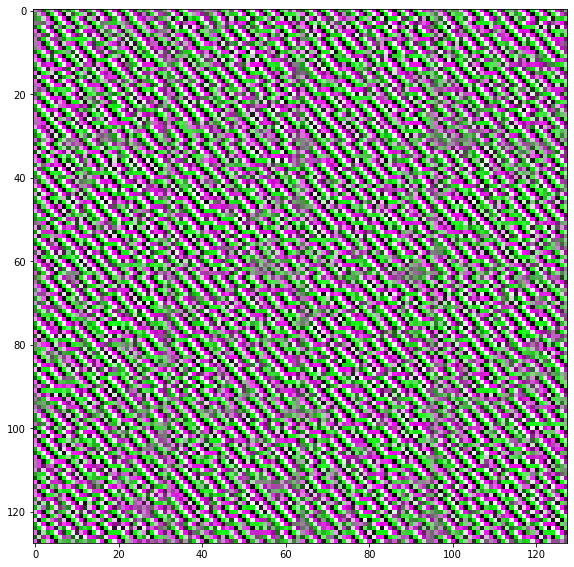

In [133]:
grid = model(16).detach().cpu().numpy()
if grid.shape[1] > 1:
    grid = np.transpose(grid, (0, 2, 3, 1))
else:
    grid = grid[:, 0]
img = grid[0]

H, W = grid.shape[1], grid.shape[2]
grid = grid.reshape(4, 4, H, W, -1)
grid = np.concatenate(np.split(grid, 4, axis=0), axis=2)
grid = np.concatenate(np.split(grid, 4, axis=1), axis=3)
grid = grid[0, 0]
grid.shape
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(grid)
plt.tight_layout()

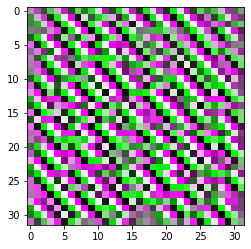

In [134]:
plt.imshow(img)